---
title: Phase 2 Metro Minds
author: Group 6
format:
    html:
        toc: true
embed-resources: true

---

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [ ]:
BFD_exp = pd.read_excel('/content/BART_Financial_Data (2).xlsx')

Ridership = pd.read_excel('/content/Ridership data.xlsx')

incomelvl = pd.read_excel('/content/midlowbart (1).xlsx')

In [ ]:
# Group by Station and Year and calculate the average entries and exits
grouped_data = Ridership.groupby(['Station', 'Year'])[['Entries', 'Exits']].mean().reset_index()

In [ ]:
#merge data together
merged_df = pd.merge(BFD_exp, grouped_data, on='Year', how='inner')
merged_df = pd.merge(merged_df, incomelvl, on='Station', how='inner')

#merged_df

In [ ]:
merged_df["Income Level"] = merged_df["Income Level"].astype("category")
merged_df["Station"] = merged_df["Income Level"].astype("category")
#merged_df.info()

# **Introduction**

We are **Metro Minds**, a team dedicated to leveraging data analysis to improve urban transportation systems. For this project, we are collaborating with **SMART (Society for Metropolitan Analysis and Research of Transportation)** to help optimize the BART system. Our goal is to provide actionable insights that enhance BART’s efficiency, convenience, and fiscal responsibility.  

To focus our analysis, we decided to work exclusively with **pre-COVID data**. This ensures that our findings reflect consistent patterns unaffected by the unprecedented disruptions of the pandemic, allowing SMART to implement informed, long-term strategies based on stable trends.  


## **Brief Data Summary**

To analyze the factors influencing BART ridership and spending patterns, we utilize three primary datasets sourced from BART’s public reports:  

1. **BART’s Annual Comprehensive Financial Report (2013–2019):** This dataset provides detailed financial data, including annual expenditures, revenue, and allocation of resources across stations.  
2. **BART Ridership Demographic Data (2015):** This dataset captures key demographic information about BART riders, such as income levels, age, and other socioeconomic variables.  
3. **BART Ridership Usage by Station Data (2013-2019):** This dataset includes station-level usage patterns, such as daily ridership counts, peak usage times, and station-specific trends.  

By integrating these datasets, we aim to investigate how spending impacts ridership trends over time, with a particular focus on stations serving disadvantaged groups and income-based variations pre-COVID. To support our analysis, we will present summary visualizations that highlight the relationships between predictors (e.g., expenditure, demographics) and the target variable (ridership). These visualizations will provide a foundation for selecting and justifying the predictors used in our model.  



## Summary Visualizations

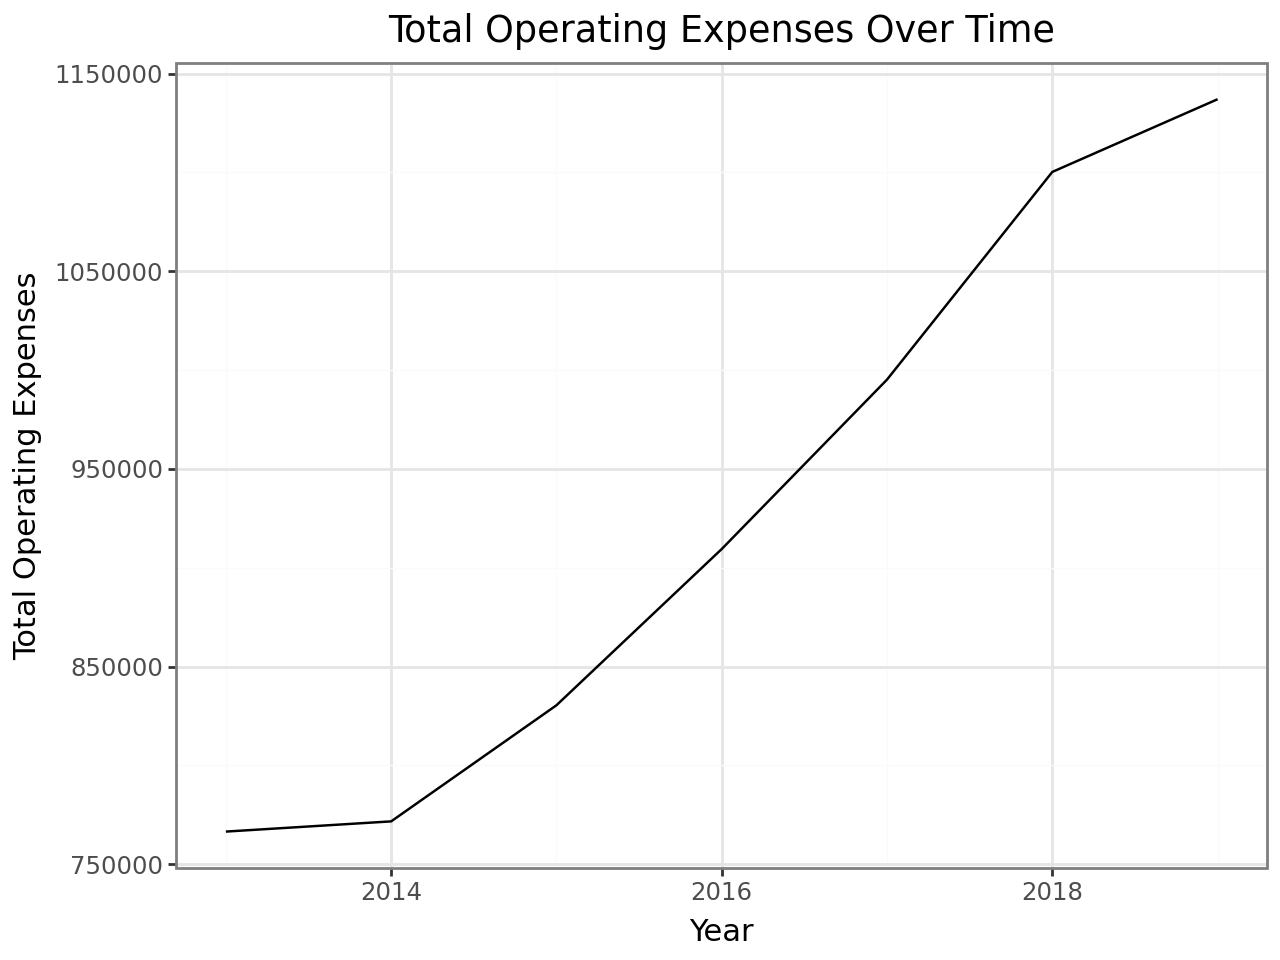

In [ ]:
(
    ggplot(merged_df, aes(x='Year', y='Total operating expenses'))
    + geom_line()
    + labs(title='Total Operating Expenses Over Time',
           x='Year',
           y='Total Operating Expenses')
    + theme_bw()
)


Here, we see operating expenses increase each year. This emphasizes BART's continuous efforts to improve the stations and the increasing costs of maintenence.

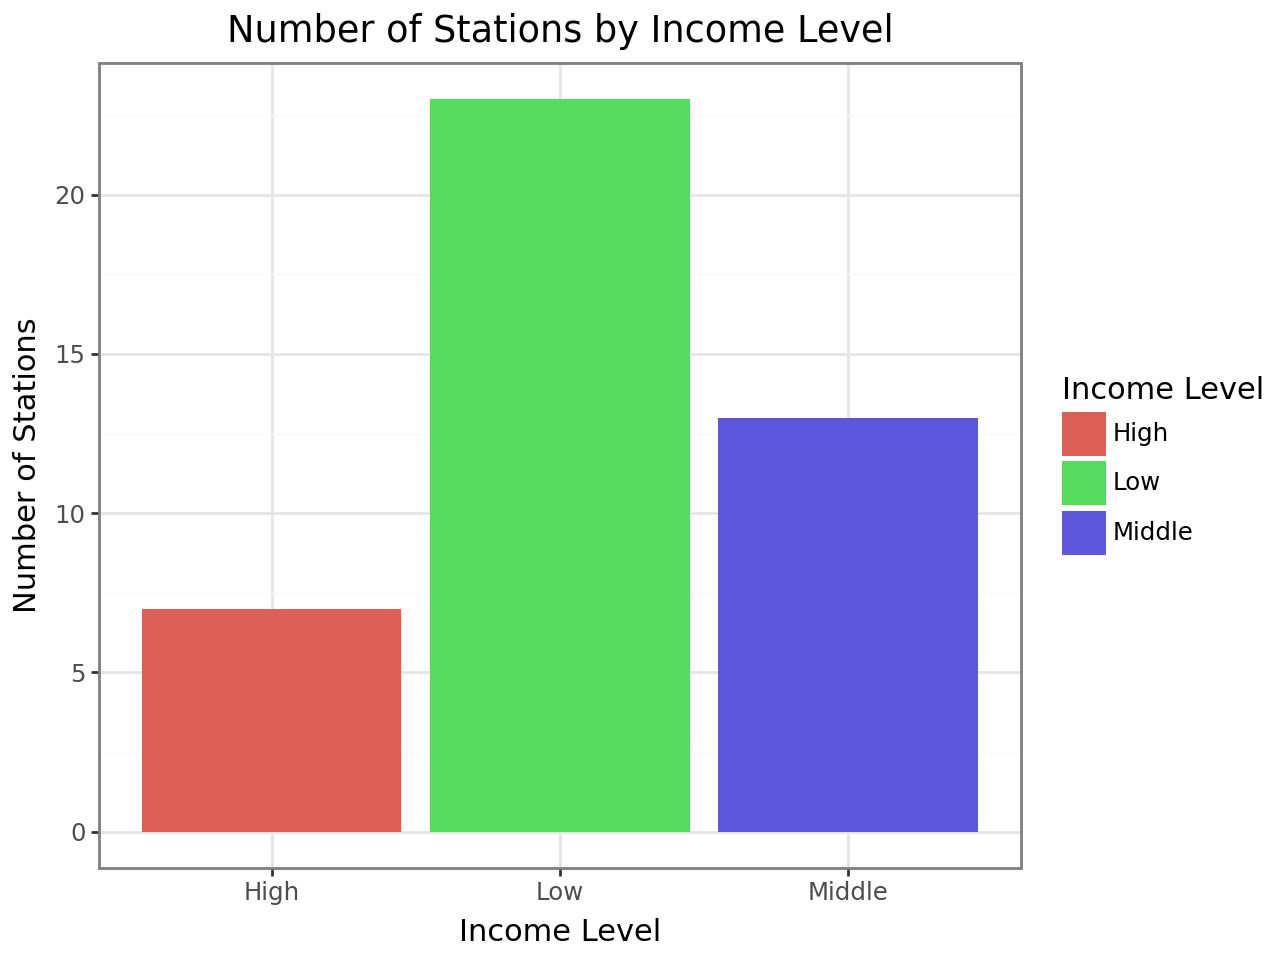

In [ ]:
stations2018 = merged_df[merged_df['Year'] == 2018]


(
    ggplot(stations2018, aes(x='Income Level', fill='Income Level'))
    + geom_bar()
    + labs(title='Number of Stations by Income Level',
           x='Income Level',
           y='Number of Stations')
    + theme_bw()
)

We calculated the average household income for each BART station and categorized them into three income groups: low-income (below \$75,000), middle-income (\$75,000 to \$150,000), and high-income (above \$150,000). This bar graph illustrates that the majority of BART stations primarily serve low-income individuals, followed by middle-income and high-income groups.

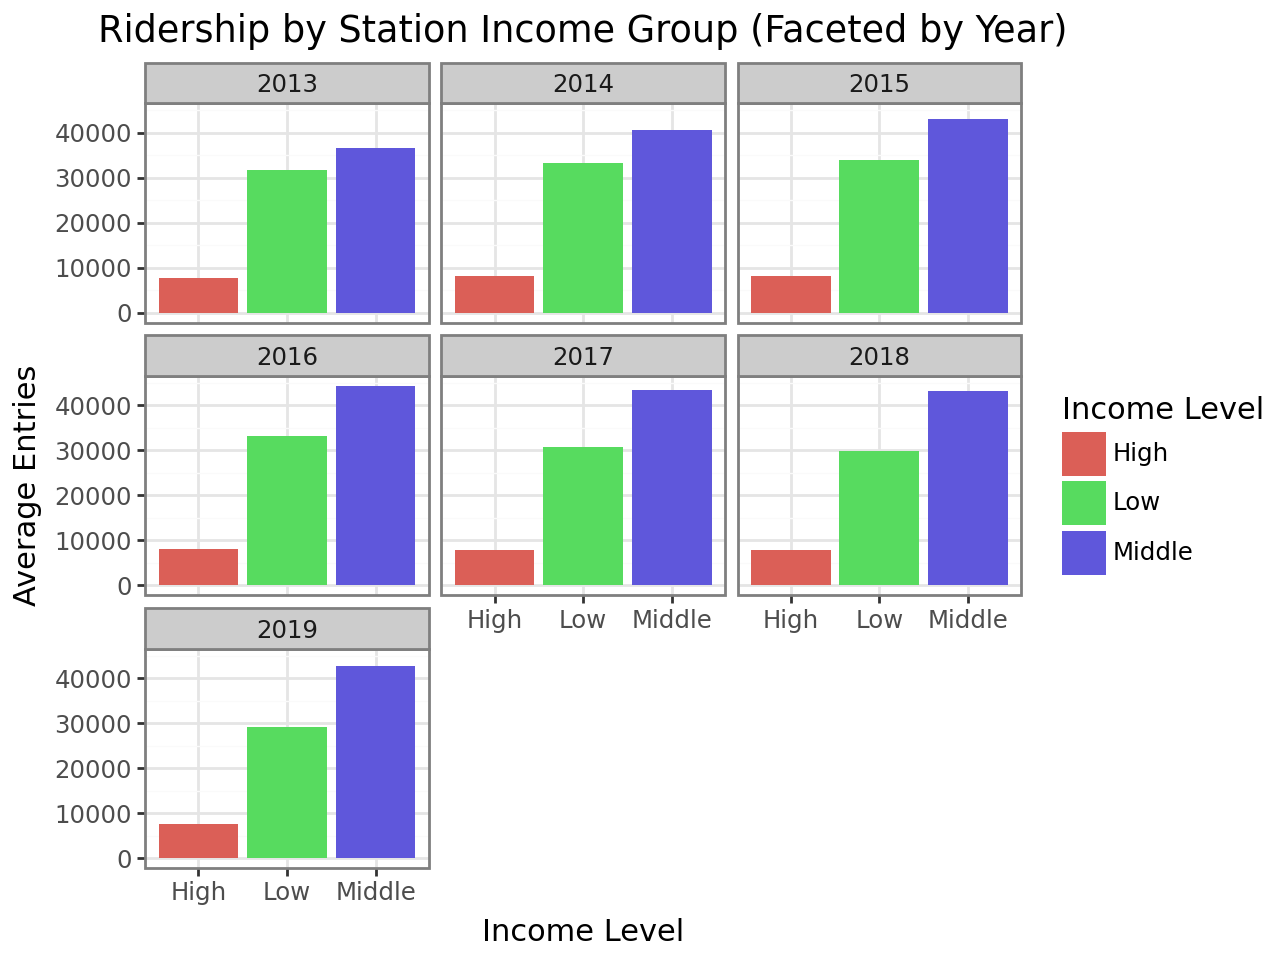

In [ ]:
#graph ridership by station income group as bar graph faceted by year

(
    ggplot(merged_df, aes(x='Income Level', y='Entries', fill='Income Level'))
    + geom_bar(stat='identity', position='dodge')
    + facet_wrap('~Year')
    + labs(title='Ridership by Station Income Group (Faceted by Year)',
           x='Income Level',
           y='Average Entries')
    + theme_bw()
)

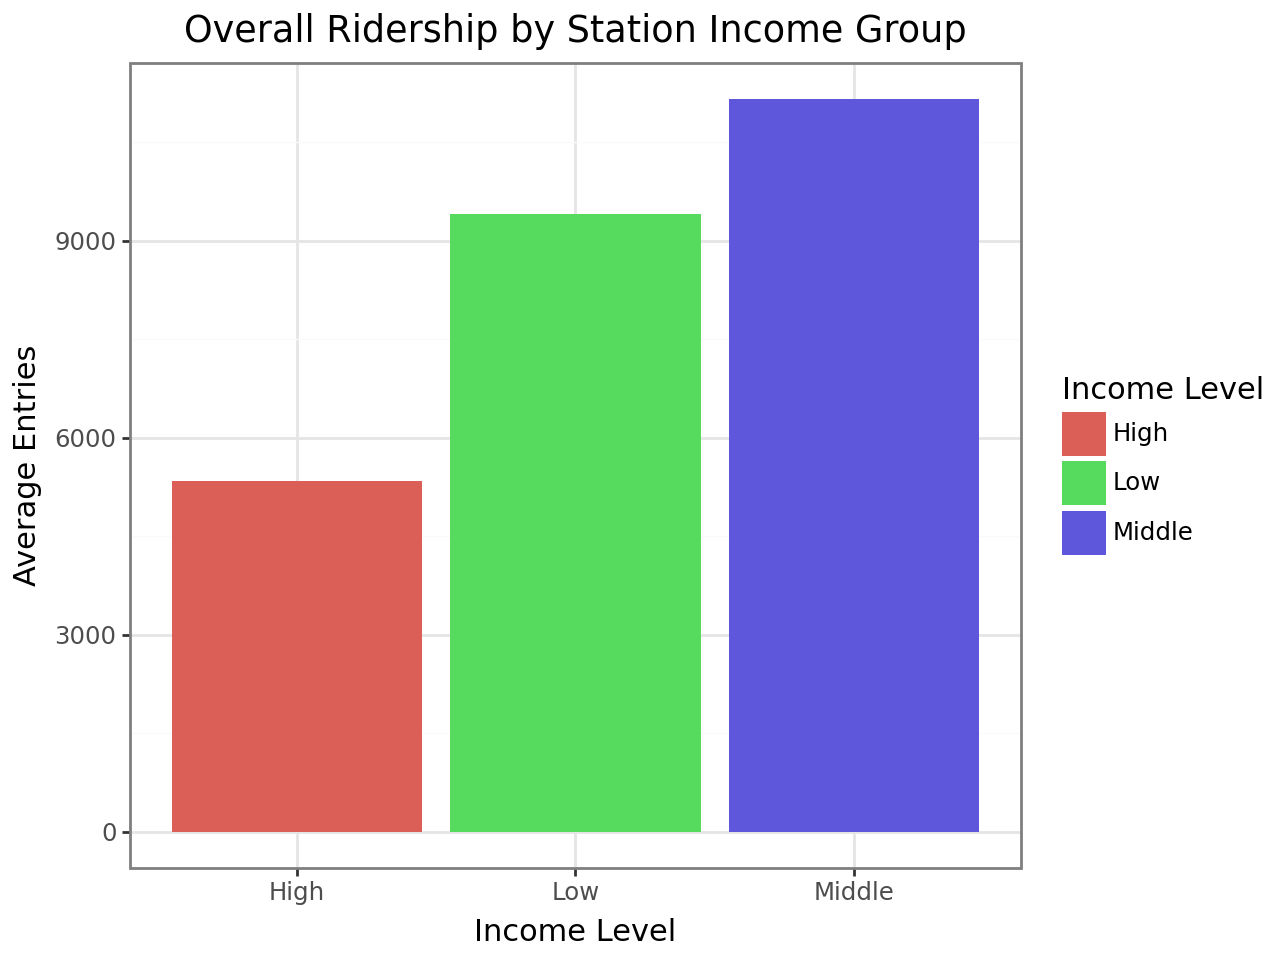

In [ ]:
#graph ridership by station income group as bar graph

(
    ggplot(merged_df, aes(x='Income Level', y='Entries', fill='Income Level'))
    + geom_bar(stat='summary', fun_data='mean_se')  # Calculate mean and standard error
    + labs(title='Overall Ridership by Station Income Group',
           x='Income Level',
           y='Average Entries')
    + theme_bw()
)

This bar graph represents ridership by station income group, showing on average, the middle class uses BART the most. The ridership for the low-income group increases until 2015 and then decreases gradually to 2019. The ridership for the middle-class grows until 2015 and stays pretty constant till 2019. We do not see much movement with the high-income group.

# **Major Questions and Planned Models**

**What are our most important predictors in determining Ridership Entries?**

Planned Model Specifications:
Linear Regression: Ridership as the target variable, city spending and income level as the predictor.

Feature Set: Expenditure data, station-level ridership data, and income levels.


In [ ]:
y=merged_df['Entries']
x=merged_df.drop(columns=['Entries', 'Station', "Year", "Exits"])

#pipeline

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop = "first"),
    ["Income Level"]),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

pipeline_lr = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

pipeline_lr.fit(x, y)

y_pred = pipeline_lr.predict(x)


In [ ]:
# Extract feature names from the ColumnTransformer
feature_names = pipeline_lr.named_steps['preprocessing'].get_feature_names_out(input_features=x.columns)
coefficients = pipeline_lr.named_steps['linear_regression'].coef_

# Combine feature names with coefficients
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Display the coefficients ascending by abs value

coefficients_df.sort_values(by="Coefficient", key =abs, ascending=False)


,Feature,Coefficient
3,standardize__Maintenance,15438.532202
5,standardize__Construction & Engineering,-14699.115913
2,standardize__Transportation,-7289.863234
1,dummify__Income Level_Middle,5810.408948
7,standardize__Depreciation,-5031.901341
6,standardize__General & Admin,4410.400478
8,standardize__Total operating expenses,4234.071615
0,dummify__Income Level_Low,4054.816179
4,standardize__Police services,2504.015713


Based on our pipeline, Maintenance is the most important predictor for entries, followed by expenditure in construction & engineering and transportation. Moving forward, we should allocate a large proportion of capital to these groups to increase ridership. However, see below for limitations in our data.

 Next Steps: Explore non-linear models (e.g., polynomial regression) if spending effects are non-linear. If we were to do further analysis, we could explore non-linear models to see how different these coefficients strengths change.

In [ ]:
x1= merged_df[["Maintenance"]]
y1= merged_df['Entries']

#y1=merged_df['Entries']
#x1=merged_df.drop(columns=['Entries', 'Station', "Year", "Exits"])

ct2 = ColumnTransformer(
    transformers=[
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

pipeline_lr = Pipeline(
  [("preprocessing", ct2),
  ("linear_regression", LinearRegression())]
)

#pipeline_lr.fit(x1, y1)
#y1_pred = pipeline_lr.predict(x1)

cross_val_scores = cross_val_score(pipeline_lr, x1, y1, cv=5, scoring = "r2").mean()
print(cross_val_scores)

-0.018952948310017658



The result indicates that the relationship between maintenance and ridership accounts for a very small percentage of the variation in ridership, as reflected by the negative R^2 value (-1.8%). While
  cannot technically be negative in standard regression contexts, a negative value can occur when the model fits worse than a horizontal line (the mean of the data), suggesting that the model may not adequately capture the true dynamics of the relationship.

This low R^2 suggests that maintenance alone is not a significant predictor of ridership, or there might be limitations in the data quality, scale, or relevance of the maintenance metrics used. It may also indicate that other influential factors—such as service frequency, fare pricing, weather, socioeconomic variables, or convenience—are not being accounted for in the model.

**How does public spending on BART stations impact ridership over time for low-, middle-, and high-income stations?**

Planned Model Specifications:

*   Model: Ridership as the target variable, grouped by income group.
*   Feature Set: Spending, station-level income classifications, and ridership trends.


<ipython-input-74-6d926c3ecd0e>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


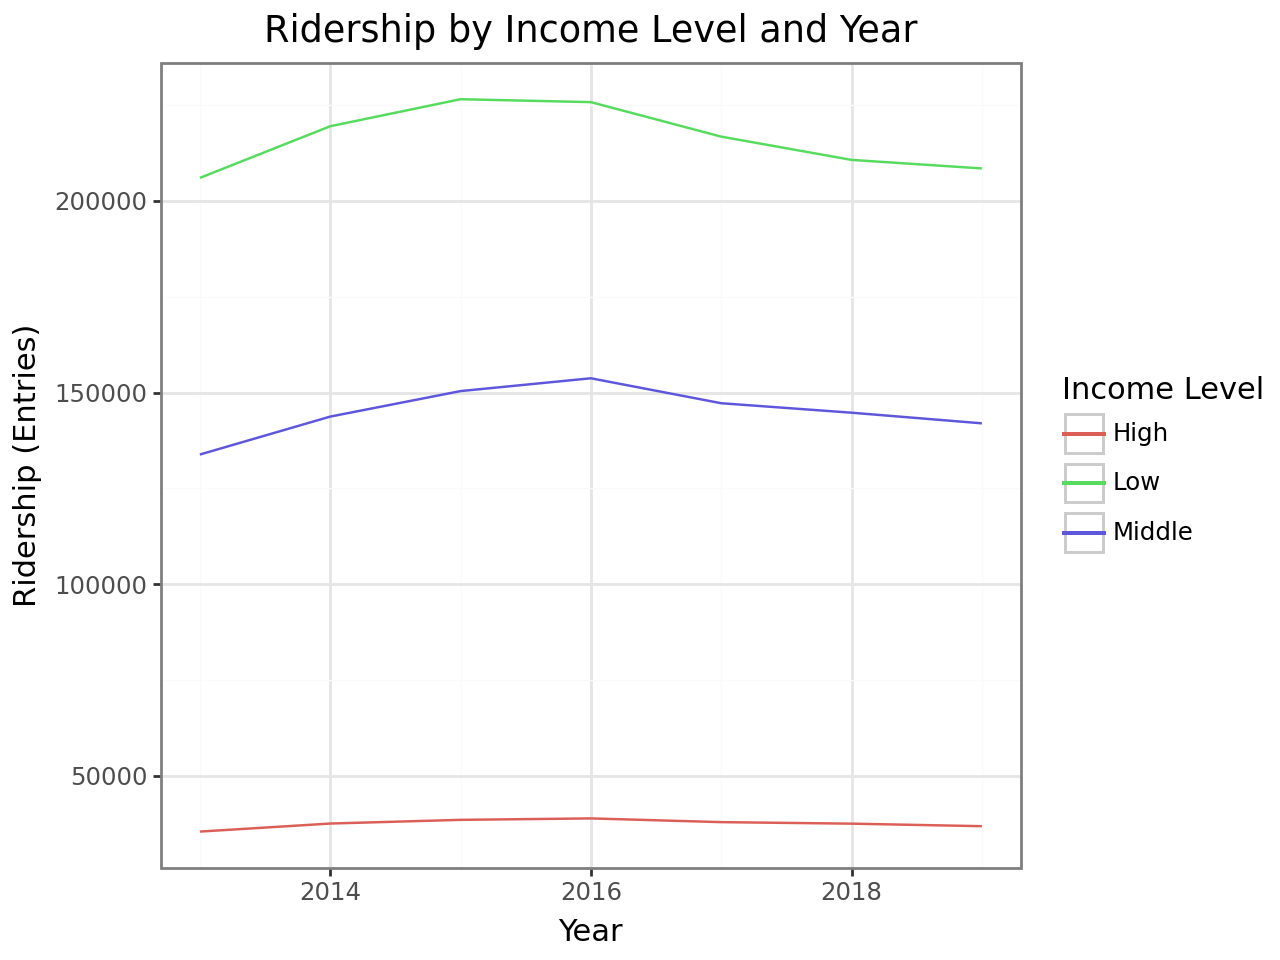

In [ ]:
# Group the data by year and income level, summing entries.
ridership_by_income_year = merged_df.groupby(['Year', 'Income Level'])['Entries'].sum().reset_index()

# Create the plot
(
    ggplot(ridership_by_income_year, aes(x='Year', y='Entries', color='Income Level'))
    + geom_line()
    + labs(title='Ridership by Income Level and Year', x='Year', y='Ridership (Entries)', color='Income Level')
    + theme_bw()
)

Preliminary Results: Preliminary analysis shows spending has a stronger impact on middle- and low-income stations than high-income stations.

Next Steps: Examine interaction terms to explore how spending and income jointly affect ridership. We would also want to find data on specific expenditures on specific BART stations, so we can understand how they are allocating those expenses, and how it specifically affects each station.

# **Model Usage**

**Practical Applications:**

Help SMART identify which stations and demographic groups benefit most from increased spending.

**Predictive Capabilities:**

Forecasting ridership trends to optimize resource allocation.
Identifying high-need stations to prioritize funding.

**Ethical Considerations:**

Ensure fairness by addressing biases in demographic data and spending decisions.

Avoid using predictions to justify reducing services to disadvantaged groups.

Promote transparency by sharing methodology and results with the public.


## **Conclusion**  

The final fitted models aim to serve as a critical tool for SMART to understand and improve the efficiency, accessibility, and fiscal responsibility of BART operations. By analyzing pre-COVID data, these models provide some insights into the relationship between spending and ridership trends, helping to identify which stations and demographic groups may benefit most from investments. However, it is important to acknowledge the significant limitations of our current model.  

The low predictive power of our model indicates that none of the included variables effectively explain ridership trends. This suggests that the current dataset is insufficient, either due to missing key factors or the limited scope of the data used. Maintenance spending, for example, showed virtually no relationship with ridership, emphasizing the need for additional and more granular data to capture the true drivers of ridership behavior.  

Despite its limitations, the model offers a starting point and highlights areas for improvement in future iterations. Expanding data collection to include variables such as socioeconomic factors, service quality metrics, and external influences (e.g., weather, economic conditions) could lead to a more accurate and actionable model. Additionally, leveraging newer data sources and more advanced modeling techniques may uncover patterns and predictors that are currently hidden.  

Finally, while the current model's predictive capabilities are limited, it underscores the importance of fairness, transparency, and equity in decision-making. By prioritizing underserved communities and ensuring data-driven decisions align with these values, SMART can continue to make progress toward optimizing resource allocation and improving the overall effectiveness of BART operations.